<a href="https://colab.research.google.com/github/pr1me1/learning_lab/blob/master/practise/custom_datasets/fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch kaggle torchinfo tqdm pillow

In [2]:
!export KAGGLE_API_TOKEN=KGAT_23646b633759593115b2c132f4cbf8c3

In [3]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("shreyapmaher/fruits-dataset-images")

print("Path to dataset files:", path)

100%|██████████| 205M/205M [00:02<00:00, 75.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shreyapmaher/fruits-dataset-images/versions/1


In [4]:
!mkdir -p /content/fruits
!cp -r {path}/* /content/fruits/

set_dir = Path("/content/fruits")

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
      print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(Path(set_dir))

There are 1 directories and 0 images in /content/fruits
There are 9 directories and 0 images in /content/fruits/images
There are 0 directories and 40 images in /content/fruits/images/strawberry fruit
There are 0 directories and 40 images in /content/fruits/images/banana fruit
There are 0 directories and 40 images in /content/fruits/images/chickoo fruit
There are 0 directories and 40 images in /content/fruits/images/apple fruit
There are 0 directories and 40 images in /content/fruits/images/orange fruit
There are 0 directories and 40 images in /content/fruits/images/cherry fruit
There are 0 directories and 40 images in /content/fruits/images/mango fruit
There are 0 directories and 40 images in /content/fruits/images/grapes fruit
There are 0 directories and 40 images in /content/fruits/images/kiwi fruit


In [6]:
main_set_path = set_dir / "images"

main_set_path.exists()

True

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
import random

random.seed(42)

class CustomFruitDataset(Dataset):
    def __init__(self, root_dir, transform=None, split_ratio: list = [0.8, 0.1, 0.1], target: str = "train"):
        self.transforms = transform
        self.root_dir = Path(root_dir)

        self.class_names = sorted(entry.name for entry in root_dir.iterdir() if entry.is_dir())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        all_paths = list(self.root_dir.glob("*/*.jpg"))

        random.shuffle(all_paths)

        total_len = len(all_paths)
        train_end = int(split_ratio[0] * total_len)
        val_end = int((split_ratio[0] + split_ratio[1]) * total_len)

        if target == "train":
            self.paths = all_paths[:train_end]
        elif target == "val":
            self.paths = all_paths[train_end:val_end]
        elif target == "test":
            self.paths = all_paths[val_end:]
        else:
            raise ValueError(f"Invalid target '{target}'. Must be 'train', 'val', or 'test'.")

    def load_image(self, index: int):
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)

        if self.transforms:
            img = self.transforms(img)

        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        return img, class_idx

In [8]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor()
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor()
    ]
)

In [9]:
train_set = CustomFruitDataset(
    root_dir=main_set_path,
    transform=test_transforms,
    target="train",
)

len(train_set)

252

In [10]:
validation_set = CustomFruitDataset(
    root_dir=main_set_path,
    transform=test_transforms,
    target="val",
)

len(validation_set), validation_set[0][0].shape

(31, torch.Size([3, 224, 224]))

In [11]:
test_set = CustomFruitDataset(
    root_dir=main_set_path,
    transform=test_transforms,
    target="test",
)

len(test_set), test_set[0][0].shape

(32, torch.Size([3, 224, 224]))

In [12]:
class_names = test_set.class_names
class_names, test_set.class_to_idx

(['apple fruit',
  'banana fruit',
  'cherry fruit',
  'chickoo fruit',
  'grapes fruit',
  'kiwi fruit',
  'mango fruit',
  'orange fruit',
  'strawberry fruit'],
 {'apple fruit': 0,
  'banana fruit': 1,
  'cherry fruit': 2,
  'chickoo fruit': 3,
  'grapes fruit': 4,
  'kiwi fruit': 5,
  'mango fruit': 6,
  'orange fruit': 7,
  'strawberry fruit': 8})

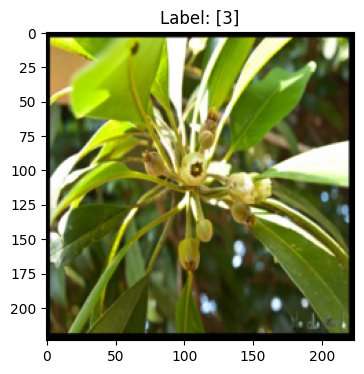

torch.Size([3, 224, 224])

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4, 4))

img, label = test_set[0]
plt.imshow(img.permute(1,2,0))
plt.title(f"Label: {[label]}")
plt.show()

img.shape

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

validation_loader = DataLoader(
    dataset=validation_set,
    batch_size=2*BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=2*BATCH_SIZE,
    shuffle=False
)

train_loader, validation_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7eb822c40680>,
 <torch.utils.data.dataloader.DataLoader at 0x7eb846b0a720>)

In [15]:
from torch import nn
from torchinfo import summary
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

class FruitClassifier(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56, out_features=output_shape)
    )

  def forward(self, tensor: torch.Tensor):
    tensor = self.layer1(tensor)
    tensor = self.layer2(tensor)
    tensor = self.classifier(tensor)
    return tensor


model = FruitClassifier(input_shape=img.shape[0], hidden_units=10, output_shape=len(class_names)).to(device)
summary(model=model, input_size=(BATCH_SIZE, img.shape[0], img.shape[1], img.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
FruitClassifier                          [4, 9]                    --
├─Sequential: 1-1                        [4, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [4, 10, 224, 224]         280
│    └─ReLU: 2-2                         [4, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [4, 10, 224, 224]         910
│    └─ReLU: 2-4                         [4, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [4, 10, 112, 112]         --
├─Sequential: 1-2                        [4, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [4, 10, 112, 112]         910
│    └─ReLU: 2-7                         [4, 10, 112, 112]         --
│    └─Conv2d: 2-8                       [4, 10, 112, 112]         910
│    └─ReLU: 2-9                         [4, 10, 112, 112]         --
│    └─MaxPool2d: 2-10                   [4, 10, 56, 56]           --
├─Sequentia

In [16]:
import torch

def accuracy_fn(y_true, y_pred):
  equals = torch.eq(y_true, y_pred).sum().item()
  return (equals / len(y_pred)) * 100

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

In [18]:
def train_steps(
    dataloader,
    model,
    loss_fn,
    optimizer,
    acc_fn,
    device = device
):
  train_loss, train_acc = 0, 0
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    model.to(device)

    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += acc_fn(y, y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [19]:
def val_steps(
    dataloader,
    model,
    loss_fn,
    acc_fn,
    device = device
):
  val_loss, val_acc = 0, 0
  with torch.inference_mode():
    for batch, (x, y) in enumerate(dataloader):
      x, y = x.to(device), y.to(device)
      model.to(device)

      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      val_loss += loss.item()
      val_acc += acc_fn(y, y_pred.argmax(dim=1))

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
  return val_loss, val_acc

In [20]:
def eval_model(
    model,
    dataloader,
    loss_fn,
    acc_fn,
    device = device
):
  model.to(device)
  loss, acc = 0, 0
  with torch.inference_mode():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      logits = model(x)
      loss += loss_fn(logits, y)
      acc += acc_fn(y, logits.argmax(dim=1))
    loss /= len(dataloader)
    acc /= len(dataloader)

  return {
      "model": model.__class__.__name__,
      "loss": loss.item(),
      "accuracy": acc
  }

In [21]:
from tqdm.auto import tqdm

def train(
    train_dataloader,
    val_dataloader,
    model,
    optimizer,
    loss_fn,
    acc_fn,
    device = device,
    epochs = 5
):
  results = {
      "train_loss": [],
      "train_acc": [],
      "val_loss": [],
      "val_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_steps(
        train_dataloader,
        model,
        loss_fn,
        optimizer,
        acc_fn,
        device,
    )
    validation_loss, validation_acc = val_steps(
        val_dataloader,
        model,
        loss_fn,
        acc_fn,
        device
    )

    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f}% | "
            f"val_loss: {validation_loss:.4f} | "
            f"val_acc: {validation_acc:.4f}%"
    )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["val_loss"].append(validation_loss.item() if isinstance(validation_loss, torch.Tensor) else validation_loss)
    results["val_acc"].append(validation_acc.item() if isinstance(validation_acc, torch.Tensor) else validation_acc)

  return results

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
model_results = train(
    train_loader,
    validation_loader,
    model,
    optimizer,
    loss_fn,
    accuracy_fn,
    device=device,
    epochs=epochs
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2375 | train_acc: 11.1111% | val_loss: 2.1950 | val_acc: 16.5179%
Epoch: 2 | train_loss: 2.0898 | train_acc: 14.2857% | val_loss: 1.9910 | val_acc: 33.0357%
Epoch: 3 | train_loss: 1.9836 | train_acc: 30.1587% | val_loss: 2.0795 | val_acc: 26.3393%
Epoch: 4 | train_loss: 1.8083 | train_acc: 32.5397% | val_loss: 1.4792 | val_acc: 48.6607%
Epoch: 5 | train_loss: 1.5394 | train_acc: 39.6825% | val_loss: 1.3172 | val_acc: 68.3036%
Epoch: 6 | train_loss: 1.2378 | train_acc: 57.1429% | val_loss: 1.1015 | val_acc: 90.1786%
Epoch: 7 | train_loss: 0.9973 | train_acc: 69.0476% | val_loss: 1.2226 | val_acc: 60.2679%
Epoch: 8 | train_loss: 0.8177 | train_acc: 70.6349% | val_loss: 1.2177 | val_acc: 80.8036%
Epoch: 9 | train_loss: 0.6744 | train_acc: 83.7302% | val_loss: 0.8296 | val_acc: 87.0536%
Epoch: 10 | train_loss: 0.3748 | train_acc: 92.4603% | val_loss: 0.9743 | val_acc: 93.3036%


In [23]:
from typing import Dict, List, Tuple

def plot_curve_function(
    results: Dict[str, List[float]]
):
  train_loss = results["train_loss"]
  test_loss = results["val_loss"]

  train_acc = results["train_acc"]
  test_acc = results["val_acc"]

  epochs = range(len(results["val_acc"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, test_loss, label='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label='train_acc')
  plt.plot(epochs, test_acc, label='validation_acc')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()


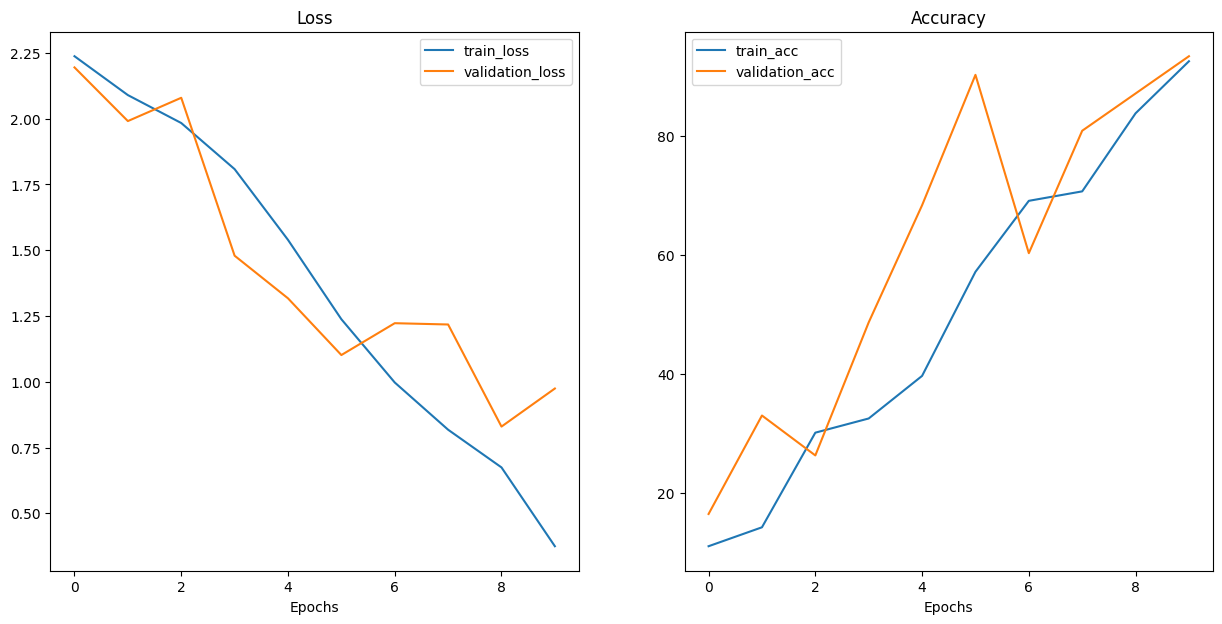

In [24]:
plot_curve_function(model_results)

In [25]:
eval = eval_model(
    model=model,
    dataloader=test_loader,
    loss_fn=loss_fn,
    acc_fn = accuracy_fn
)
eval

{'model': 'FruitClassifier', 'loss': 0.4463973939418793, 'accuracy': 93.75}